In [1]:
from definitions import *
from plots import *
from Experiment import *
from simpsom.plots import add_cluster
from sklearn.cluster import DBSCAN, KMeans

%load_ext autoreload
%autoreload 2

# Weather regimes (Grams 2017)

In [2]:
exp_z = ClusteringExperiment(
    'ERA5', 'Geopotential', '500', None, None, -80, 40, 30, 89.5, 
    'anomaly', None, 'doy', {'dayofyear': ('win', 90)}, 
    {'detrended': False, 'time': ('fft', 10)}, inner_norm=1
)

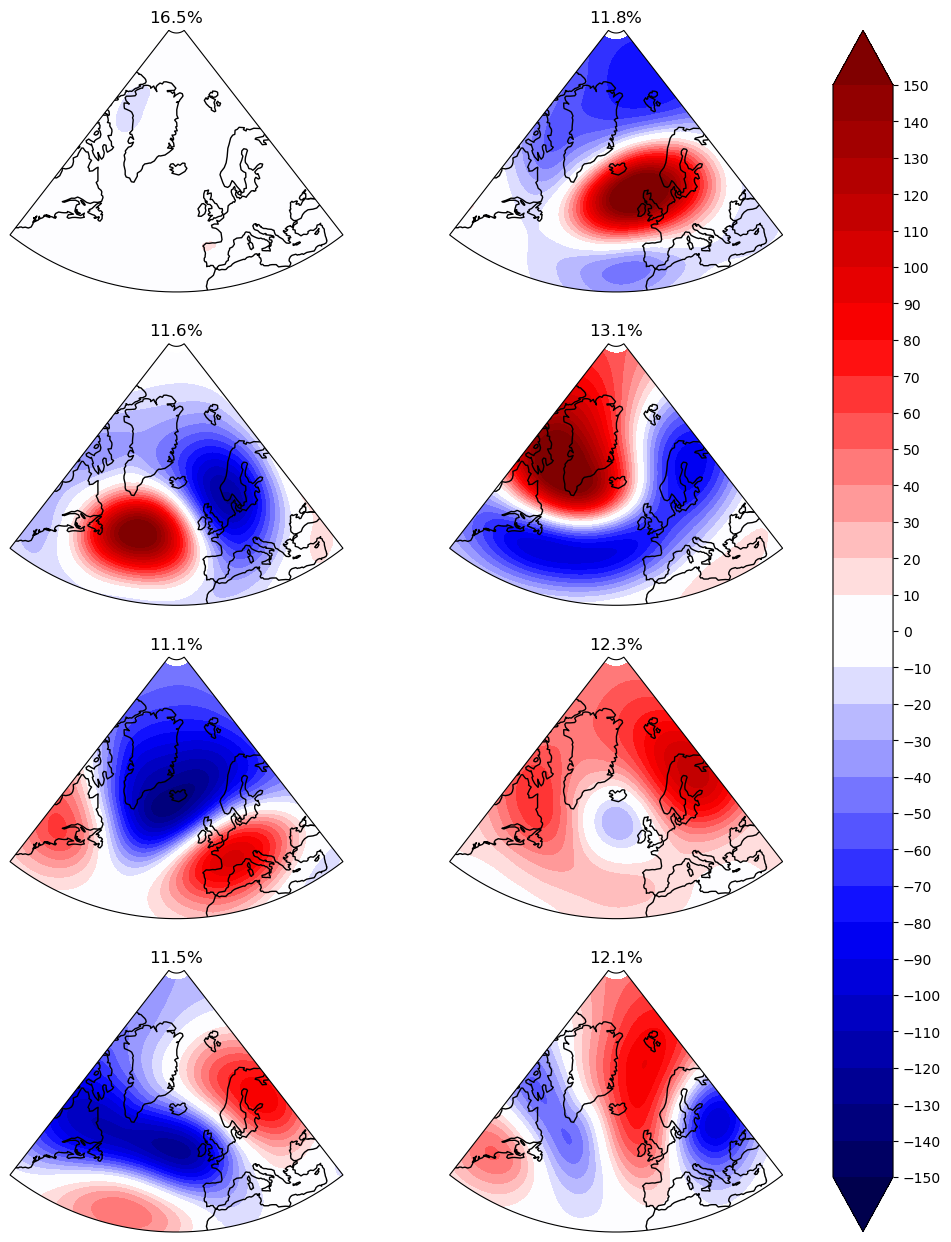

In [4]:
# centers, _ = exp_z.cluster(7, 7)
clu = Clusterplot(4, 2, lambert_projection=True, region=(-80, 40, 30, 89.5))
titles = [f'${ratio * 100:.1f}\%$' for ratio in centers.ratios.values]
clu.add_contourf(centers, titles=titles, nlevels=16)

In [14]:
pcas = load_pickle('/storage/scratch/users/hb22g102/ERA5/Geopotential/500/box_-80_40_30_89/doy_doywin90/timefft10/pca_9_anomaly_JJA.pkl')

In [15]:
np.sum(pcas.explained_variance_ratio_)

0.7737982502404629

# Severin's RWB events

In [12]:
if NODE == 'CLIM':
    streamers = xr.open_dataset('/scratch3/severin/rwb_index/era5/era5_av_streamer_75.nc')
streamers = streamers.sel(time=(streamers.time.dt.season=='JJA'))


NameError: name 'streamers' is not defined

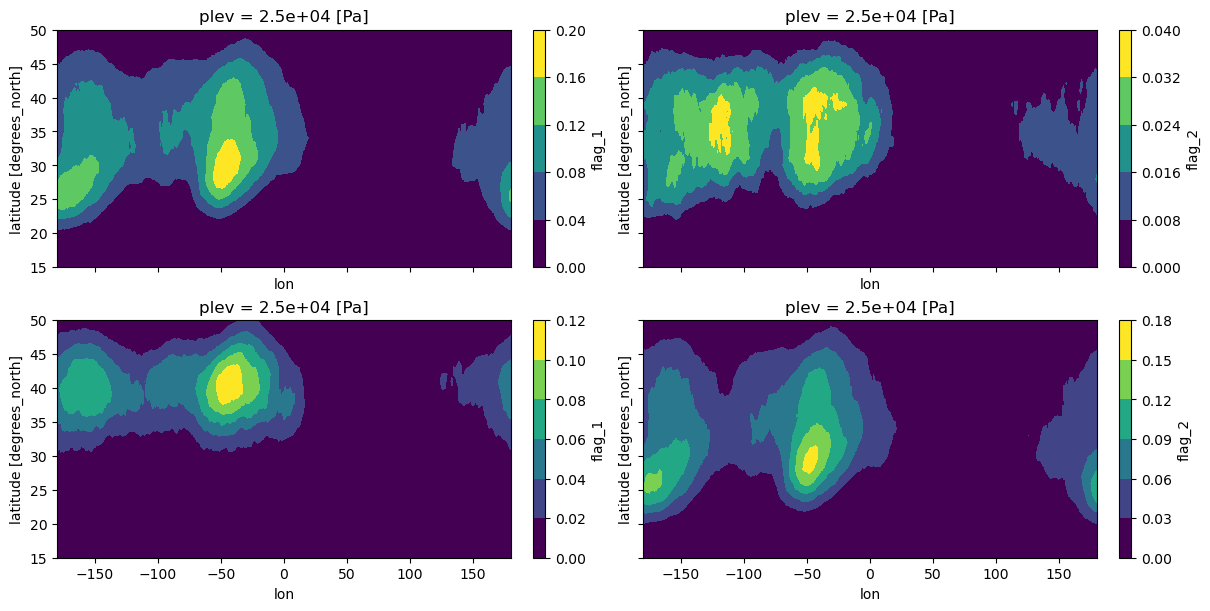

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
axes = axes.flatten()
streamers['flag_1'].isin([1, 2]).mean(dim='time').plot.contourf(ax=axes[0])
(streamers['flag_2'] == 1).mean(dim='time').plot.contourf(ax=axes[1])
(streamers['flag_1'] == 2).mean(dim='time').plot.contourf(ax=axes[2])
(streamers['flag_2'] == 2).mean(dim='time').plot.contourf(ax=axes[3])
for ax in axes:
    ax.set_ylim([15, 50])

# Dani's blocking

In [ ]:
blocks = xr.open_dataarray('/scratch3/steidani/data/era5/blocking/z500/Blocks_Z500.nc')
block_df = pd.read_csv('/scratch3/steidani/data/era5/blocking/z500/Blocks_lifecycle_Z500.csv')

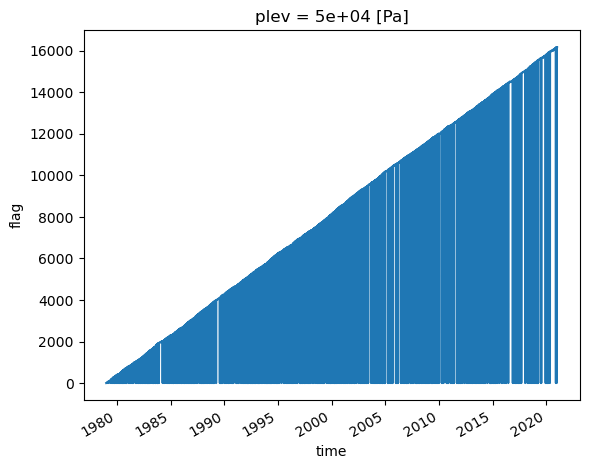

In [ ]:
blocks.max(dim=['lon', 'lat']).plot()

In [ ]:
len(blocks.time)

15341

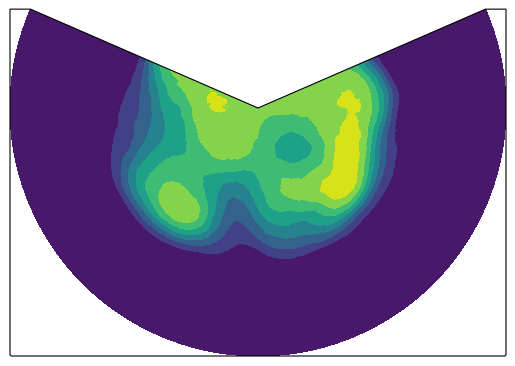

In [ ]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.LambertConformal()))
hehe = (blocks > 0).mean(dim='time')
ax.contourf(hehe.lon, hehe.lat, hehe, transform=ccrs.PlateCarree())

# Barriopedro

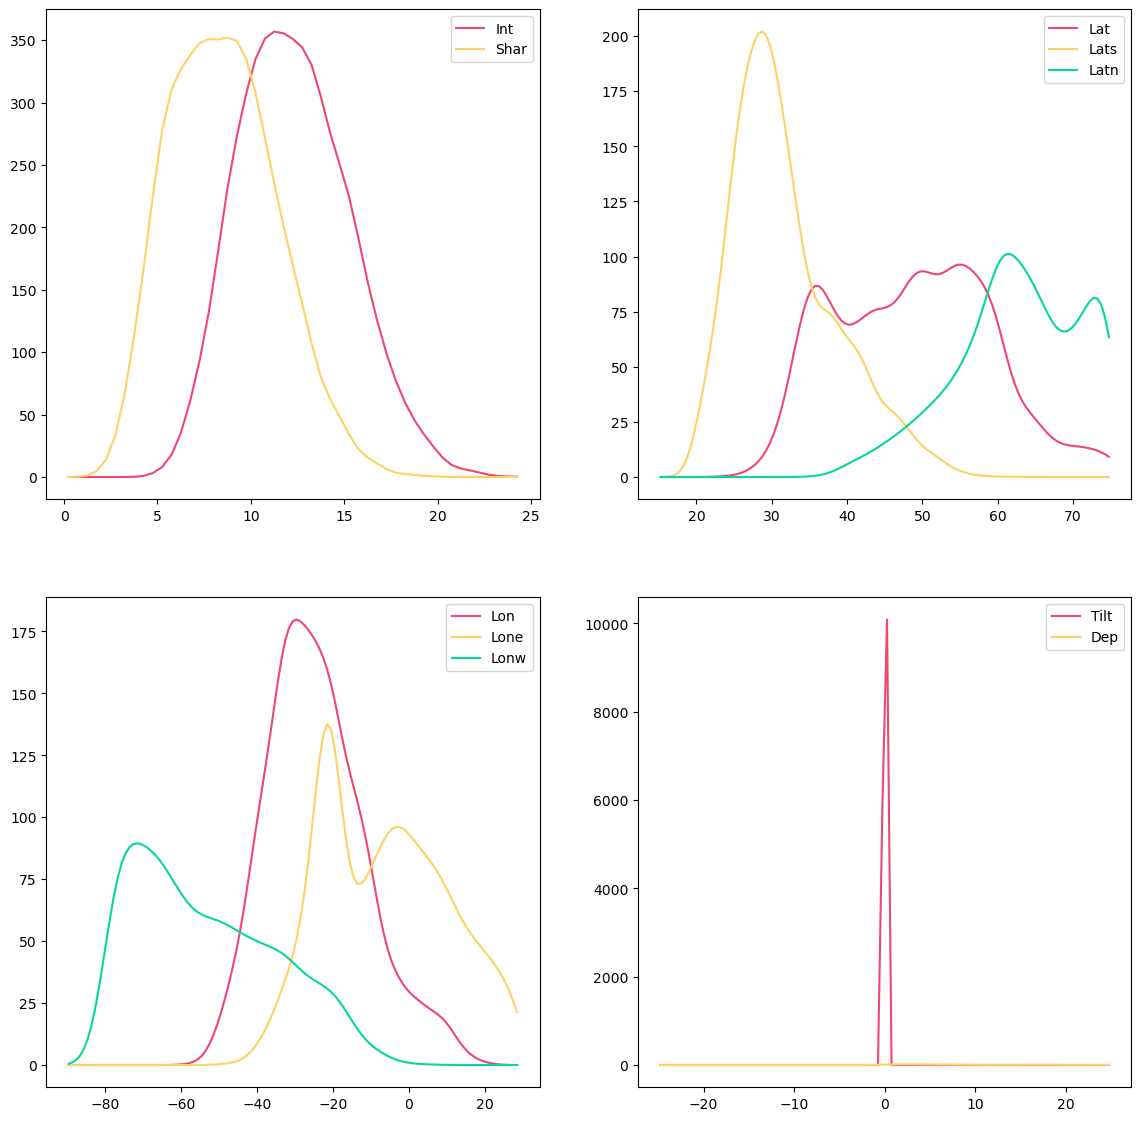

In [ ]:
exp_u = ZooExperiment('ERA5', None, -80, 40, 20, 80)
# exp_u.compute_Zoo(True)
# timeseries, ax, season=None, bins=LATBINS, **kwargs
Zoo = xr.open_dataset(exp_u.get_Zoo_path())
fig, axes = plt.subplots(2, 2, figsize=(14, 14))
axes = axes.flatten()
mapping = [
    ["Int", "Shar"],
    ["Lat", "Lats", "Latn"],
    ["Lon", "Lone", "Lonw"],
    ["Tilt", "Dep"],
]
bins = [WINDBINS, LATBINS, LONBINS, DEPBINS]
for i, group in enumerate(mapping):
    ax = axes[i]
    for j, key in enumerate(group):
        midpoints, gkde = kde(
            Zoo[key], "DJF", bins[i], scaled=True, return_x=True, bw_method=0.2
        )
        ax.plot(midpoints, gkde, color=COLORS5[j], label=key)
    ax.legend()
plt.show()


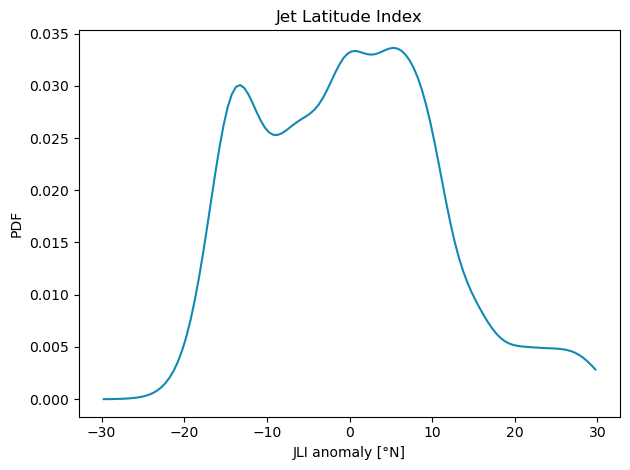

In [ ]:
fig, ax = plt.subplots(tight_layout=True)
midpoints, gkde = kde(
    Zoo["Lat_anomaly"],
    "DJF",
    np.arange(-30, 30.1, 0.5),
    scaled=False,
    return_x=True,
    bw_method=0.2,
)
ax.plot(midpoints, gkde, color=COLORS5[-3], label=key)
ax.set_title("Jet Latitude Index")
ax.set_xlabel("JLI anomaly [°N]")
ax.set_ylabel("PDF")
plt.savefig("Figures/JLI_winter.png")


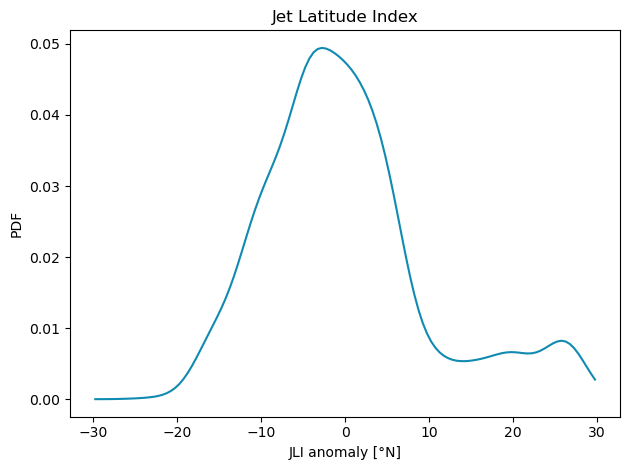

In [ ]:
fig, ax = plt.subplots(tight_layout=True)
midpoints, gkde = kde(
    Zoo["Lat_anomaly"],
    "JJA",
    np.arange(-30, 30.1, 0.5),
    scaled=False,
    return_x=True,
    bw_method=0.2,
)
ax.plot(midpoints, gkde, color=COLORS5[-3], label=key)
ax.set_title("Jet Latitude Index")
ax.set_xlabel("JLI anomaly [°N]")
ax.set_ylabel("PDF")
plt.savefig("Figures/JLI_summer.png")


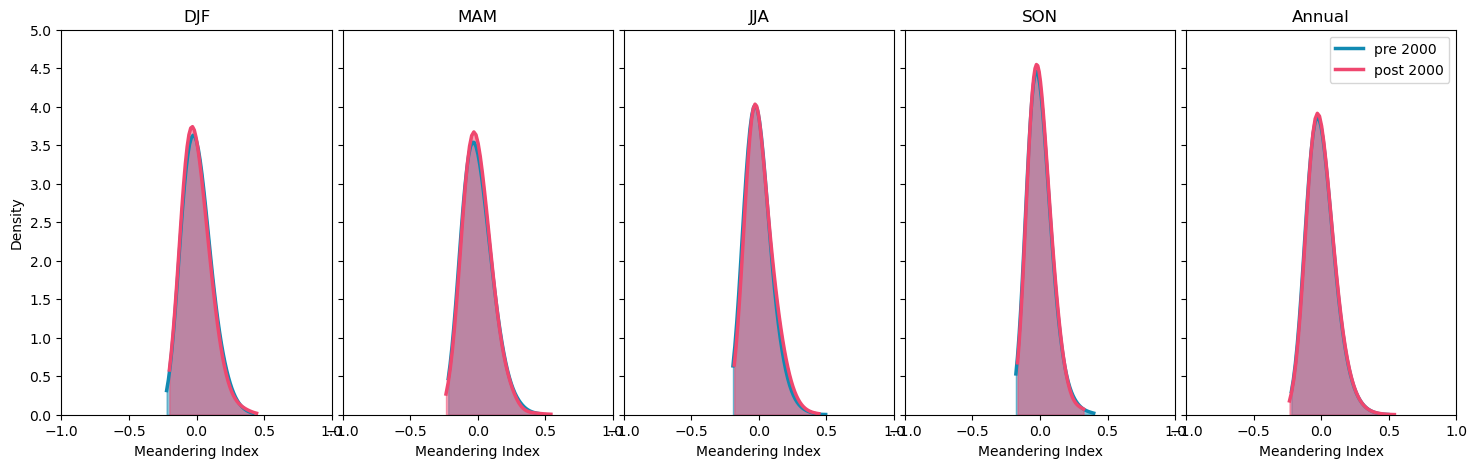

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(18, 5), sharey=True)
daM = Zoo['Mea_detrended']
early = daM.isel(time=(daM.time.dt.year < 2000))
recent = daM.isel(time=(daM.time.dt.year >= 2000))
fig.subplots_adjust(wspace=0.04)
for i, season in enumerate(["DJF", "MAM", "JJA", "SON", "Annual"]):
    kde_early = kde(early, season, 50, scaled=False, return_x=True)
    kde_recent = kde(recent, season, 50, scaled=False, return_x=True)
    axes[i].plot(*kde_early, label="pre 2000", color=COLORS5[3], lw=2.5)
    axes[i].plot(*kde_recent, label="post 2000", color=COLORS5[0], lw=2.5)
    axes[i].fill_between(kde_early[0], 0, kde_early[1], color=COLORS5[3], alpha=0.5)
    axes[i].fill_between(kde_recent[0], 0, kde_recent[1], color=COLORS5[0], alpha=0.5)
    axes[i].set_title(season)
    axes[i].set_xlabel("Meandering Index")
    axes[i].set_yticks(np.arange(0, 5.1, 0.5))
    axes[i].set_xlim([-1, 1])
    axes[i].set_ylim([0, 5])
axes[0].set_ylabel("Density")
axes[-1].legend()
plt.draw()
plt.savefig("Figures/meandering.png")

## LDT on Lat, Int

In [ ]:
Zoo = xr.open_dataset(f"{DATADIR}/ERA5/processed/BarriopedroZooDetrended.nc")
winter = np.isin(Zoo.time.dt.month, [1, 2, 12])
JLI = Zoo["Lat_anomaly"].isel(time=winter)
JSI = Zoo["Int_anomaly"].isel(time=winter)


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True, sharey=False)
bins = [np.arange(-10, 10.5, 0.25), np.arange(-8, 8.01, 0.25)]
for i, series in enumerate([JLI, JSI]):
    ax = axes[i]
    for j, n in enumerate(range(15, 121, 15)):
        coarsened = series.rolling(time=n).mean()

        x, gkde = kde(coarsened, bins=bins[i], return_x=True)
        y = -np.log(gkde) / n
        y -= np.amin(y)
        ax.plot(x, y, color=COLORS10[j], label=f"n={n}")
    ax.set_title(series.name)
    ax.legend()


In [ ]:
coarsened = JSI.coarsen(time=60, boundary="trim").mean()
x, gkde = kde(coarsened, bins=np.arange(-10, 10.01, 0.1), return_x=True)
y = -np.log(gkde) / n
a, b, c = np.polyfit(x, y, deg=2, w=1 / y)


In [ ]:
plt.plot(x, y)
plt.plot(x, a * x * x + b * x + c)


In [ ]:
plt.plot(x, gkde)
x2 = np.linspace(-25, 25, 201)
plt.plot(x, np.exp(-n * (a * x * x + b * x + c)))
plt.plot(x, normal_dist(loc=np.mean(coarsened), scale=np.std(coarsened)).pdf(x))


# Stationarity

### Plot Zoo Autocorrelation:

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(20, 16), tight_layout=True)
axes = axes.flatten(order="F")
dataset = "ERA5"
datadir = f"{DATADIR}/{dataset}/processed"  # daint
autocorrs = xr.open_dataset(f"{datadir}/Zoo_autocorrs.nc")
howmany = len(autocorrs.coords["lag"])
newlist = []
for key in list(Zoo.data_vars.keys())[:11]:
    for suffix in ["_anomaly"]:
        newlist.append(f"{key}{suffix}")
telatex = r"$T^e_{\rho}$"
tdlatex = r"$T^d_{\rho}$"
tclatex = r"$T^c_{\rho}$"
lw = 2
for i, varname in enumerate(newlist):
    te = np.argmax(autocorrs[varname].values <= 1 / np.exp(1))
    td = 1 + 2 * np.sum(autocorrs[varname])
    tc = 1 + np.sum(
        autocorrs[varname] * (1 - np.arange(1, howmany + 1) / (howmany + 1))
    )
    axes[i].plot(np.arange(howmany), autocorrs[varname], color=COLORS5[0], lw=lw)
    axes[i].plot([te, te], [0, 1], label=telatex, color=COLORS5[2], lw=lw)
    axes[i].plot([tc, tc], [0, 1], label=tclatex, color=COLORS5[3], lw=lw)
    axes[i].plot([td, td], [0, 1], label=tdlatex, color=COLORS5[4], lw=lw)
    axes[i].grid()
    axes[i].legend()
    axes[i].set_title(
        f"{varname}, {telatex}={te}, {tdlatex}={td:.3f}, {tclatex}={tc:.3f}"
    )
    axes[i].set_ylabel("Autocorrelation")
    axes[i].set_xlabel("Lag time [days]")
plt.savefig("Figures/zoo_autocorrs.png")


# Hidden Markov Model

In [ ]:
Zoo = xr.open_dataset(f"{DATADIR}/ERA5/processed/BarriopedroZooDetrended.nc")
Y = Zoo["Lat_detrended"].isel(time=Zoo.time.dt.season == "DJF").values


In [ ]:
n_components = 3
n_sel = 50
n_sam = 4500
means = []
sigmas = []
transmats = []
for i in range(n_sel):
    ghmm = GaussianHMM(n_components=n_components).fit(Y[:, None])
    transmats.append(ghmm.transmat_)
    means.append(ghmm.means_[:, 0])
    sigmas.append(ghmm.covars_[:, 0, 0])
# im = plt.imshow(ghmm.transmat_)
# plt.colorbar(im)


In [ ]:
means = np.stack(means)
sigmas = np.stack(sigmas)
transmats = np.stack(transmats)
idx2 = np.argsort(means, axis=1)
means = np.take_along_axis(means, idx2, axis=1)
sigmas = np.take_along_axis(sigmas, idx2, axis=1)
transmatss = np.take_along_axis(transmats, idx2[:, :, np.newaxis], axis=1)
transmatss = np.take_along_axis(transmatss, idx2[:, np.newaxis, :], axis=2)
mean = np.mean(means, axis=0)
sigma = np.mean(sigmas, axis=0)
transmat = np.mean(transmatss, axis=0)
c = np.real(np.log(np.linalg.eigvals(transmat).astype(np.complex128)))
c[np.isclose(c, 0)] = 0
for i in range(n_components):
    thisnorm = normal_dist(loc=mean[i], scale=np.sqrt(sigma[i]))
    X = np.linspace(thisnorm.ppf(0.005), thisnorm.ppf(0.995), 100)
    plt.plot(X, thisnorm.pdf(X) / n_components, label=f"$c={c[i]:.2f}$")
plt.plot(
    *kde(
        Y,
        season=None,
        bins=np.arange(-30, 30.1, 0.5),
        scaled=False,
        return_x=True,
        bw_method=0.2,
    ),
    label="JLI, KDE",
)
plt.legend()


In [ ]:
meanghmm = GaussianHMM(n_components=3, covariance_type="full")
meanghmm.transmat_ = transmat
meanghmm.means_ = mean.reshape(3, 1)
meanghmm.covars_ = sigma.reshape(3, 1, 1)
meanghmm.startprob_ = [0, 0, 1]


In [ ]:
Zda = xr.open_dataarray(
    f"{DATADIR}/ERA5/Geopotential/500/north_atlantic/detrended.nc"
).isel(time=Zoo.time.dt.season == "DJF")
states = meanghmm.predict(Y.reshape(-1, 1))
to_plot = [Zda.isel(time=states == i).mean(dim="time") for i in range(n_components)]
fig, axes, cbar = clusterplot(
    1, n_components, to_plot, 11, 150, cbar_ylabel="Z500 [m]", cmap="PRGn"
)
plt.show()


In [ ]:
Sda = xr.open_dataarray(f"{DATADIR}/ERA5/Wind/300/box_-90_30_30_80/s_detrended.nc")[
    1:
].isel(time=Zoo.time.dt.season == "DJF")
states = meanghmm.predict(Y.reshape(-1, 1))
to_plot = [Sda.isel(time=states == i).mean(dim="time") for i in range(n_components)]
fig, axes, cbar = clusterplot(1, n_components, to_plot, 7, 12, cbar_ylabel="S300 [m/s]")
plt.show()


# Duncan's hotspells

### Create hotspells file

In [ ]:
list_of_dates = np.loadtxt("hotspells.csv", delimiter=",", dtype=np.datetime64)
hotspells = {}
dataset = "ERA5"
keys = ["South", "West", "Balkans", "Scandinavia", "Russia", "Arctic"]
minus = 21
plus = 5
for j, key in enumerate(keys):
    hotspells[key] = []
    dates = np.sort(list_of_dates[:, j])
    dates = dates[
        ~(np.isnat(dates) | (np.datetime_as_string(dates, unit="Y") == "2022"))
    ]
    print(key, len(dates))
    for i, date in enumerate(dates):
        tsta = date - np.timedelta64(minus, "D") + np.timedelta64(9, "h")
        tend = date + np.timedelta64(plus, "D") + np.timedelta64(9, "h")
        thisds = xr.open_dataset(
            f"{DATADIR}/{dataset}/Wind/300/dailymean/{np.datetime_as_string(date, unit='Y')}.nc"
        )
        thisds = thisds.sel(time=pd.date_range(tsta, tend, freq="1D"))
        thisds = thisds.assign_coords({"time": np.arange(-minus, plus + 1)})
        hotspells[key].append(thisds)
    hotspells[key] = xr.concat(hotspells[key], dim="hotspell").assign_coords(
        {"hotspell": dates}
    )
with open(f"{DATADIR}/{dataset}/processed/hotspells_uv300.pkl", "wb") as handle:
    pkl.dump(hotspells, handle)


- Replace time coords with range(21), keep track of the center date (or all time as index but not coord) : done
- create aggregates : mean, std, correlation with T, look at individuals for all clusters
- compare with duncan's plot, also get boundaries of the clusters
- cluster wind myself and compare backwards

### Study hotspells

In [ ]:
dataset = "ERA5"
with open(f"{DATADIR}/{dataset}/processed/hotspells_uv300.pkl", "rb") as handle:
    hotspells = pkl.load(handle)

meanwind_hotspell = xr.concat(
    [hotspell.mean(dim="hotspell") for hotspell in hotspells.values()], dim="region"
).assign_coords({"region": list(hotspells.keys())})


In [ ]:
meanwind_hotspell_NA = meanwind_hotspell.sel(latitude=np.arange(30, 90, 0.5)).load()
meanwind_hotspell_NA["s"] = np.sqrt(
    meanwind_hotspell_NA["u"] ** 2 + meanwind_hotspell_NA["v"] ** 2
)
lon_NA = meanwind_hotspell_NA.longitude.values
lat_NA = meanwind_hotspell_NA.latitude.values
meanwind_hotspell_NA.to_netcdf(f"{DATADIR}/{dataset}/processed/hotspells_uv300_NA.nc")


In [ ]:
dataset = "ERA5"
meanwind_hotspell_NA = xr.open_dataset(
    f"{DATADIR}/{dataset}/processed/hotspells_uv300_NA.nc"
)
lon_NA = meanwind_hotspell_NA.longitude.values
lat_NA = meanwind_hotspell_NA.latitude.values


In [ ]:
ticker_region = pnw.Select(
    name="Region", options=meanwind_hotspell_NA.region.values.tolist()
)
ticker_variable = pnw.Select(
    name="Component", options=list(meanwind_hotspell_NA.data_vars.keys())
)
ticker_kind = pnw.Select(name="Kind", options=["contour", "contourf", "quadmesh"])

tsta, tend = int(np.amin(meanwind_hotspell_NA.time.values)), int(
    np.amax(meanwind_hotspell_NA.time.values)
)
slider = pnw.IntSlider(name="Day around center", start=tsta, end=tend)

extent = [
    np.amin(lon_NA),
    np.amax(lon_NA) + 0.5,
    np.amin(lat_NA),
    np.amax(lat_NA) + 0.5,
]
# boundary = mpath.Path(np.stack([np.linspace(180, 0, 361), np.full(361, 30)]).transpose())
boundary = make_boundary_path(*extent)
boundary.vertices = boundary.vertices[
    (boundary.vertices[:, 1] == 30) | (boundary.vertices[:, 1] == 90)
]
nlevels = 11
levels0 = np.delete(
    np.append(np.linspace(-30, 0, nlevels), np.linspace(0, 30, nlevels)), nlevels - 1
)
levels = np.delete(levels0, nlevels - 1)
cmap = "seismic"
cmap = cm.get_cmap(cmap)
norm = mpl.colors.BoundaryNorm(levels, cmap.N, extend="both")
im = cm.ScalarMappable(norm=norm, cmap=cmap)


def crop_axis(plot, element):
    b = plot.state
    b.axes[0].set_boundary(boundary, transform=ccrs.PlateCarree())
    if len(b.axes) == 1:
        b.colorbar(im, ax=b.axes[0], spacing="proportional")
    else:
        b.get_figure().colorbar(im, cax=b.axes[1], spacing="proportional")
    b.axes[1].set_yticks(levels)


a = meanwind_hotspell_NA.interactive.sel(region=ticker_region, time=slider).hvplot(
    kind=ticker_kind,
    x="longitude",
    y="latitude",
    z=ticker_variable,
    cmap="seismic",
    colorbar=False,
    color=None,
    linewidth=1.5,
    symmetric=True,
    projection="NorthPolarStereo",
    geo=True,
    coastline="110m",
    levels=levels,
    xlabel=None,
    ylabel=None,
    xaxis=None,
    yaxis=None,
    title=ticker_variable,
    width=700,
    height=400,
)
# a = a.opts(hooks=[crop_axis])

pn.Row(a.widgets(), a.holoviews())


## Zoo during hotspells

### Create hotspells_zoo file

In [ ]:
list_of_dates = np.loadtxt("hotspells.csv", delimiter=",", dtype=np.datetime64)
hotspells_Zoo = {}
dataset = "ERA5"
keys = ["South", "West", "Balkans", "Scandinavia", "Russia", "Arctic"]
dataset = "ERA5"
datadir = f"{DATADIR}/{dataset}/processed"
Zoo = xr.open_dataset(f"{datadir}/BarriopedroZooDetrended.nc")
Zookeys = list(Zoo.data_vars.keys())  # copy and not view !
minus = 21
plus = 5
for varname in Zookeys:
    if varname[-11:].split("_")[-1] == "climatology":
        del Zoo[varname]
for j, key in enumerate(keys):
    hotspells_Zoo[key] = []
    dates = np.sort(list_of_dates[:, j])
    dates = dates[
        ~(np.isnat(dates) | (np.datetime_as_string(dates, unit="Y") == "2022"))
    ]
    for i, date in enumerate(dates):
        tsta = date - np.timedelta64(minus, "D") + np.timedelta64(9, "h")
        tend = date + np.timedelta64(plus, "D") + np.timedelta64(9, "h")
        thisds = Zoo.sel(time=pd.date_range(tsta, tend, freq="1D"))
        thisds.attrs["center_date"] = date
        thisds = thisds.assign_coords(
            {"time": np.arange(-minus, plus + 1)}
        ).reset_index("dayofyear", drop=True)
        hotspells_Zoo[key].append(thisds)
    hotspells_Zoo[key] = xr.concat(hotspells_Zoo[key], dim="hotspell").assign_coords(
        {"hotspell": dates}
    )
with open(f"{DATADIR}/{dataset}/processed/hotspells_Zoo.pkl", "wb") as handle:
    pkl.dump(hotspells_Zoo, handle)


### Plot

In [ ]:
%matplotlib inline
dataset = "ERA5"
datadir = f"{DATADIR}/{dataset}/processed"
Zoo = xr.open_dataset(f"{datadir}/BarriopedroZooDetrended.nc")
with open(f"{DATADIR}/{dataset}/processed/hotspells_Zoo.pkl", "rb") as handle:
    hotspells_Zoo = pkl.load(handle)

In [ ]:
fig, axes = plt.subplots(4, 3, figsize=(20, 25), tight_layout=True)
axes = axes.flatten()
for k, key in enumerate([f"{key}_anomaly" for key in ZOO]):
    ax = axes[k]
    for i, regionkey in enumerate(hotspells_Zoo):
        to_plot = hotspells_Zoo[regionkey][key].mean(dim="hotspell")
        (to_plot / np.amax(np.abs(to_plot))).plot(
            ax=ax, label=regionkey, color=COLORS10[(2 * i) % 9], lw=2
        )
        # ax.fill_between(
        #     to_plot.time,
        #     *(np.quantile(hotspells_Zoo[regionkey][key], [0.05, 0.95], axis=0) / np.amax(np.abs(to_plot)).values),
        #     color=COLORS10[(2 * i) % 9],
        #     alpha=0.1,
        # )
    ax.set_title(key)
    ax.set_xlabel("Time around center")
    ax.set_ylabel("Normalized anomaly")
    if k == 9:
        ax.legend(ncol=2)


In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 9), tight_layout=True)
axes = axes.flatten()
x = hotspells_Zoo["South"].time.values
tsta, tend = x[[0, -1]]
for k, regionkey in enumerate(hotspells_Zoo):
    ax = axes[k]
    for i, key in enumerate(
        [f"{key}_anomaly" for key in ["Lat", "Int", "Tilt", "Lon", "Mea"]]
    ):
        norm = np.amax(np.abs(Zoo[key].isel(time=Zoo.time.dt.season == "JJA")))
        to_plot = (hotspells_Zoo[regionkey][key] / norm).mean(dim="hotspell")
        quantiles = (hotspells_Zoo[regionkey][key] / norm).quantile(
            [0.1, 0.9], dim="hotspell"
        )
        ax.plot(x, to_plot, label=key.split("_")[0], color=COLORS5[i % 5], lw=2)
        ax.fill_between(x, *quantiles, color=COLORS5[i % 5], alpha=0.5)
    ax.set_title(regionkey)
    ax.set_xlabel("Days around center")
    ax.set_ylabel("Normalized anomaly")
    ax.set_xticks(np.arange(tsta, tend + 1, 2))
    if k == 5:
        ax.legend(ncol=2)


### As p-values

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 9), tight_layout=True)
axes = axes.flatten()
tsta, tend = hotspells_Zoo["South"].time.values[[0, -1]]
keys = [f"{key}_anomaly" for key in ["Lat", "Int", "Tilt", "Lon", "Mea"]]
cdfs = {key: cdf(Zoo[key].isel(time=Zoo.time.dt.season == "JJA")) for key in keys}
for k, regionkey in enumerate(hotspells_Zoo):
    ax = axes[k]
    for i, key in enumerate(keys):
        x, y = cdfs[key]
        base = hotspells_Zoo[regionkey][key].mean(dim="hotspell")
        to_plot = y[np.searchsorted(x, base)]
        ax.plot(base.time, to_plot, label=key.split("_")[0], color=COLORS5[i % 5], lw=2)
    ax.set_title(regionkey)
    ax.set_xlabel("Days around center")
    ax.set_ylabel("p-value of anomaly")
    ax.set_xticks(np.arange(tsta, tend + 1, 2))
    if k == 5:
        ax.legend(ncol=2)


#### How gaussian are those timeseries ?

In [ ]:
fig, axes = plt.subplots(4, 3, figsize=(15, 15), tight_layout=True)
axes = axes.flatten()
varkeys = [f"{key}_anomaly" for key in ZOO]
cdfs = {key: cdf(Zoo[key]) for key in varkeys}
for i, key in enumerate(varkeys):
    ax = axes[i]
    x, y = cdfs[key]
    ax.plot(x, y, "k", zorder=4)
    y2 = normal_dist.cdf(x, loc=np.mean(Zoo[key]), scale=np.std(Zoo[key], ddof=1))
    ax.plot(x, y2, "b--")
    ax.plot(x, np.abs(y - y2), "r")
    ax.set_title(f"{np.linalg.norm(np.abs(y-y2)) / len(y):.2e}")
    ax.set_xlabel(key)
    ax.set_ylabel("$p$")
    ax.grid()


## Dynamical indices during hotspells

In [ ]:
list_of_dates = np.loadtxt("hotspells.csv", delimiter=",", dtype=np.datetime64)
hotspells_dynind = {}
dataset = "ERA5"
keys = ["South", "West", "Balkans", "Scandinavia", "Russia", "Arctic"]
dataset = "ERA5"
datadir = f"{DATADIR}/{dataset}/processed"
ld = xr.open_dataarray(f"{datadir}/ld.nc")
theta = xr.open_dataarray(f"{datadir}/theta.nc")
indices = xr.Dataset({"ld": ld, "theta": theta})
indikeys = list(indices.data_vars.keys())  # copy and not view !
minus = 21
plus = 5
for j, key in enumerate(keys):
    hotspells_dynind[key] = []
    dates = np.sort(list_of_dates[:, j])
    dates = dates[
        ~(np.isnat(dates) | (np.datetime_as_string(dates, unit="Y") == "2022"))
    ]
    for i, date in enumerate(dates):
        tsta = date - np.timedelta64(minus, "D")
        tend = date + np.timedelta64(plus, "D")
        thisds = indices.sel(time=pd.date_range(tsta, tend, freq="1D"))
        thisds.attrs["center_date"] = date
        thisds = thisds.assign_coords({"time": np.arange(-minus, plus + 1)})
        hotspells_dynind[key].append(thisds)
    hotspells_dynind[key] = xr.concat(
        hotspells_dynind[key], dim="hotspell"
    ).assign_coords({"hotspell": dates})
with open(f"{DATADIR}/{dataset}/processed/hotspells_dynind.pkl", "wb") as handle:
    pkl.dump(hotspells_dynind, handle)


In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 9), tight_layout=True)
axes = axes.flatten()
tsta, tend = hotspells_dynind["South"].time.values[[0, -1]]
for k, regionkey in enumerate(hotspells_dynind):
    ax = axes[k]
    for i, key in enumerate(hotspells_dynind["South"].data_vars):
        to_plot = hotspells_dynind[regionkey][key].mean(dim="hotspell")
        (to_plot / np.amax(to_plot)).plot(
            ax=ax, label=key.split("_")[0], color=COLORS5[i % 5], lw=2
        )
    ax.set_title(regionkey)
    ax.set_xlabel("Day around center")
    ax.set_ylabel("Normalized index")
    ax.set_xticks(np.arange(tsta, tend + 1, 2))
    if k == 5:
        ax.legend(ncol=2)
